In [1]:
cd ..

/home/max/Documents/remb


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from sklearn import metrics
from sklearn.decomposition import PCA
from tqdm import tqdm

from src.simplefact import *
from src.simplefact.syntax import *
from src.reasoner import *
from src.generate import *
from src.utils import *
from src.vis import *

seed = 2022

In [3]:
onto = load_ofn('local/out/dataset/pizza.ofn', silent=True)
fact = Reasoner.from_onto(onto, timeout=None)
onto.use_annotations_as_names()
onto.use_prefix('pizza:')
C = onto.concept_by_name
R = onto.role_by_name
onto

FaCT++.Kernel: Reasoner for the SROIQ(D) Description Logic, 64-bit
Copyright (C) Dmitry Tsarkov, 2002-2017. Version 1.7.0-SNAPSHOT (01 January 2017)


<Onto 99 concepts, 4 roles, 287 axioms>

In [4]:
rng = np.random.default_rng(seed)
Nc = onto.n_concepts
Nr = onto.n_roles
gen = AxiomGenerator(rng=rng, n_concepts=Nc, n_roles=Nr, max_depth=4, p_atomic=0.95)
        
n_queries = 32_000
queries, answers, qset = [], [], set()
while len(queries) < n_queries:
    axiom = gen()
    axiom_core = core(axiom)
    if axiom_core in qset: continue
    answer = fact.check_axiom(axiom)
    queries.append(axiom_core); answers.append(int(answer)); qset.add(axiom_core)
    
print(onto.render(queries[100]))
print(len(answers))
print(np.round(np.mean(answers), 4))

LeekTopping ⊑ SpicyPizzaEquivalent
32000
0.4111


In [5]:
X_te = [core(x) for x in queries]
y_te = answers
idx_te = [0]*len(X_te)
data = idx_te, X_te, y_te

rng = np.random.default_rng(seed)

params = dict(emb_size=10, hidden_size=16, onto=onto)

T.manual_seed(seed)
unfrozen_r = NeuralReasoner(**params)

T.manual_seed(seed)
transfer_r = NeuralReasoner(**params)
transfer_r.head.load_state_dict(T.load('local/out/exp/20220715T194304/reasoner.pt'))

T.manual_seed(seed)
random_r = NeuralReasoner(**params)

params = dict(epoch_count=30, batch_size=32, lr_reasoner=0.001, lr_encoder=0.001)

print('unfrozen reasoner head')
T.manual_seed(seed)
unfrozen_log = train(data, None, unfrozen_r.head, [unfrozen_r.embs], run_name='unfrozen', **params)

print('----')

print('frozen reasoner head (transfer)')
T.manual_seed(seed)
transfer_log = train(data, None, transfer_r.head, [transfer_r.embs], freeze_reasoner=True, run_name='frozen transfer', **params)

print('----')

print('frozen reasoner head (random)')
T.manual_seed(seed)
random_log = train(data, None, random_r.head, [random_r.embs], freeze_reasoner=True, run_name='frozen random', **params)

unfrozen reasoner head
train epoch 00/30 | batch 1001/1000 | loss 0.7195 | val loss 0.7195 | acc 0.4111 | f1 0.5827 | prec 0.4111 | recall 1.0000 | roc auc 0.7200 | pr auc 0.5830 | elapsed 9.63s
train epoch 01/30 | batch 1001/1000 | loss 0.3365 | val loss 0.2085 | acc 0.9225 | f1 0.9065 | prec 0.8995 | recall 0.9137 | roc auc 0.9715 | pr auc 0.9604 | elapsed 15.74s
train epoch 02/30 | batch 1001/1000 | loss 0.1906 | val loss 0.1607 | acc 0.9417 | f1 0.9293 | prec 0.9256 | recall 0.9330 | roc auc 0.9822 | pr auc 0.9756 | elapsed 15.61s
train epoch 03/30 | batch 1001/1000 | loss 0.1400 | val loss 0.1083 | acc 0.9640 | f1 0.9564 | prec 0.9514 | recall 0.9615 | roc auc 0.9913 | pr auc 0.9886 | elapsed 15.97s
train epoch 04/30 | batch 1001/1000 | loss 0.1073 | val loss 0.0883 | acc 0.9714 | f1 0.9653 | prec 0.9651 | recall 0.9655 | roc auc 0.9940 | pr auc 0.9923 | elapsed 15.87s
train epoch 05/30 | batch 1001/1000 | loss 0.0913 | val loss 0.0806 | acc 0.9748 | f1 0.9691 | prec 0.9782 | reca

train epoch 16/30 | batch 1001/1000 | loss 0.1633 | val loss 0.1559 | acc 0.9467 | f1 0.9347 | prec 0.9415 | recall 0.9280 | roc auc 0.9830 | pr auc 0.9784 | elapsed 15.09s
train epoch 17/30 | batch 1001/1000 | loss 0.1609 | val loss 0.1543 | acc 0.9479 | f1 0.9363 | prec 0.9408 | recall 0.9320 | roc auc 0.9833 | pr auc 0.9788 | elapsed 15.54s
train epoch 18/30 | batch 1001/1000 | loss 0.1592 | val loss 0.1522 | acc 0.9486 | f1 0.9372 | prec 0.9411 | recall 0.9333 | roc auc 0.9837 | pr auc 0.9791 | elapsed 15.05s
train epoch 19/30 | batch 1001/1000 | loss 0.1577 | val loss 0.1512 | acc 0.9494 | f1 0.9383 | prec 0.9411 | recall 0.9355 | roc auc 0.9838 | pr auc 0.9795 | elapsed 15.19s
train epoch 20/30 | batch 1001/1000 | loss 0.1564 | val loss 0.1510 | acc 0.9467 | f1 0.9343 | prec 0.9467 | recall 0.9222 | roc auc 0.9841 | pr auc 0.9799 | elapsed 15.01s
train epoch 21/30 | batch 1001/1000 | loss 0.1553 | val loss 0.1490 | acc 0.9485 | f1 0.9372 | prec 0.9390 | recall 0.9355 | roc auc 0.

------
Unfrozen reasoner head
train time 411.1694583892822
             mean  std     micro
acc      0.992938  NaN  0.992938
prec     0.989773  NaN  0.989773
recall   0.993083  NaN  0.993083
f1       0.991425  NaN  0.991425
auc_roc  0.999677  NaN  0.999677
auc_pr   0.999538  NaN  0.999538
------
Frozen pre-trained reasoner head
train time 354.99916100502014
             mean  std     micro
acc      0.952719  NaN  0.952719
prec     0.950895  NaN  0.950895
recall   0.933186  NaN  0.933186
f1       0.941957  NaN  0.941957
auc_roc  0.985910  NaN  0.985910
auc_pr   0.982329  NaN  0.982329
------
Frozen random reasoner head
train time 328.49118542671204
             mean  std     micro
acc      0.773344  NaN  0.773344
prec     0.659325  NaN  0.659325
recall   0.928398  NaN  0.928398
f1       0.771062  NaN  0.771062
auc_roc  0.893251  NaN  0.893251
auc_pr   0.839056  NaN  0.839056


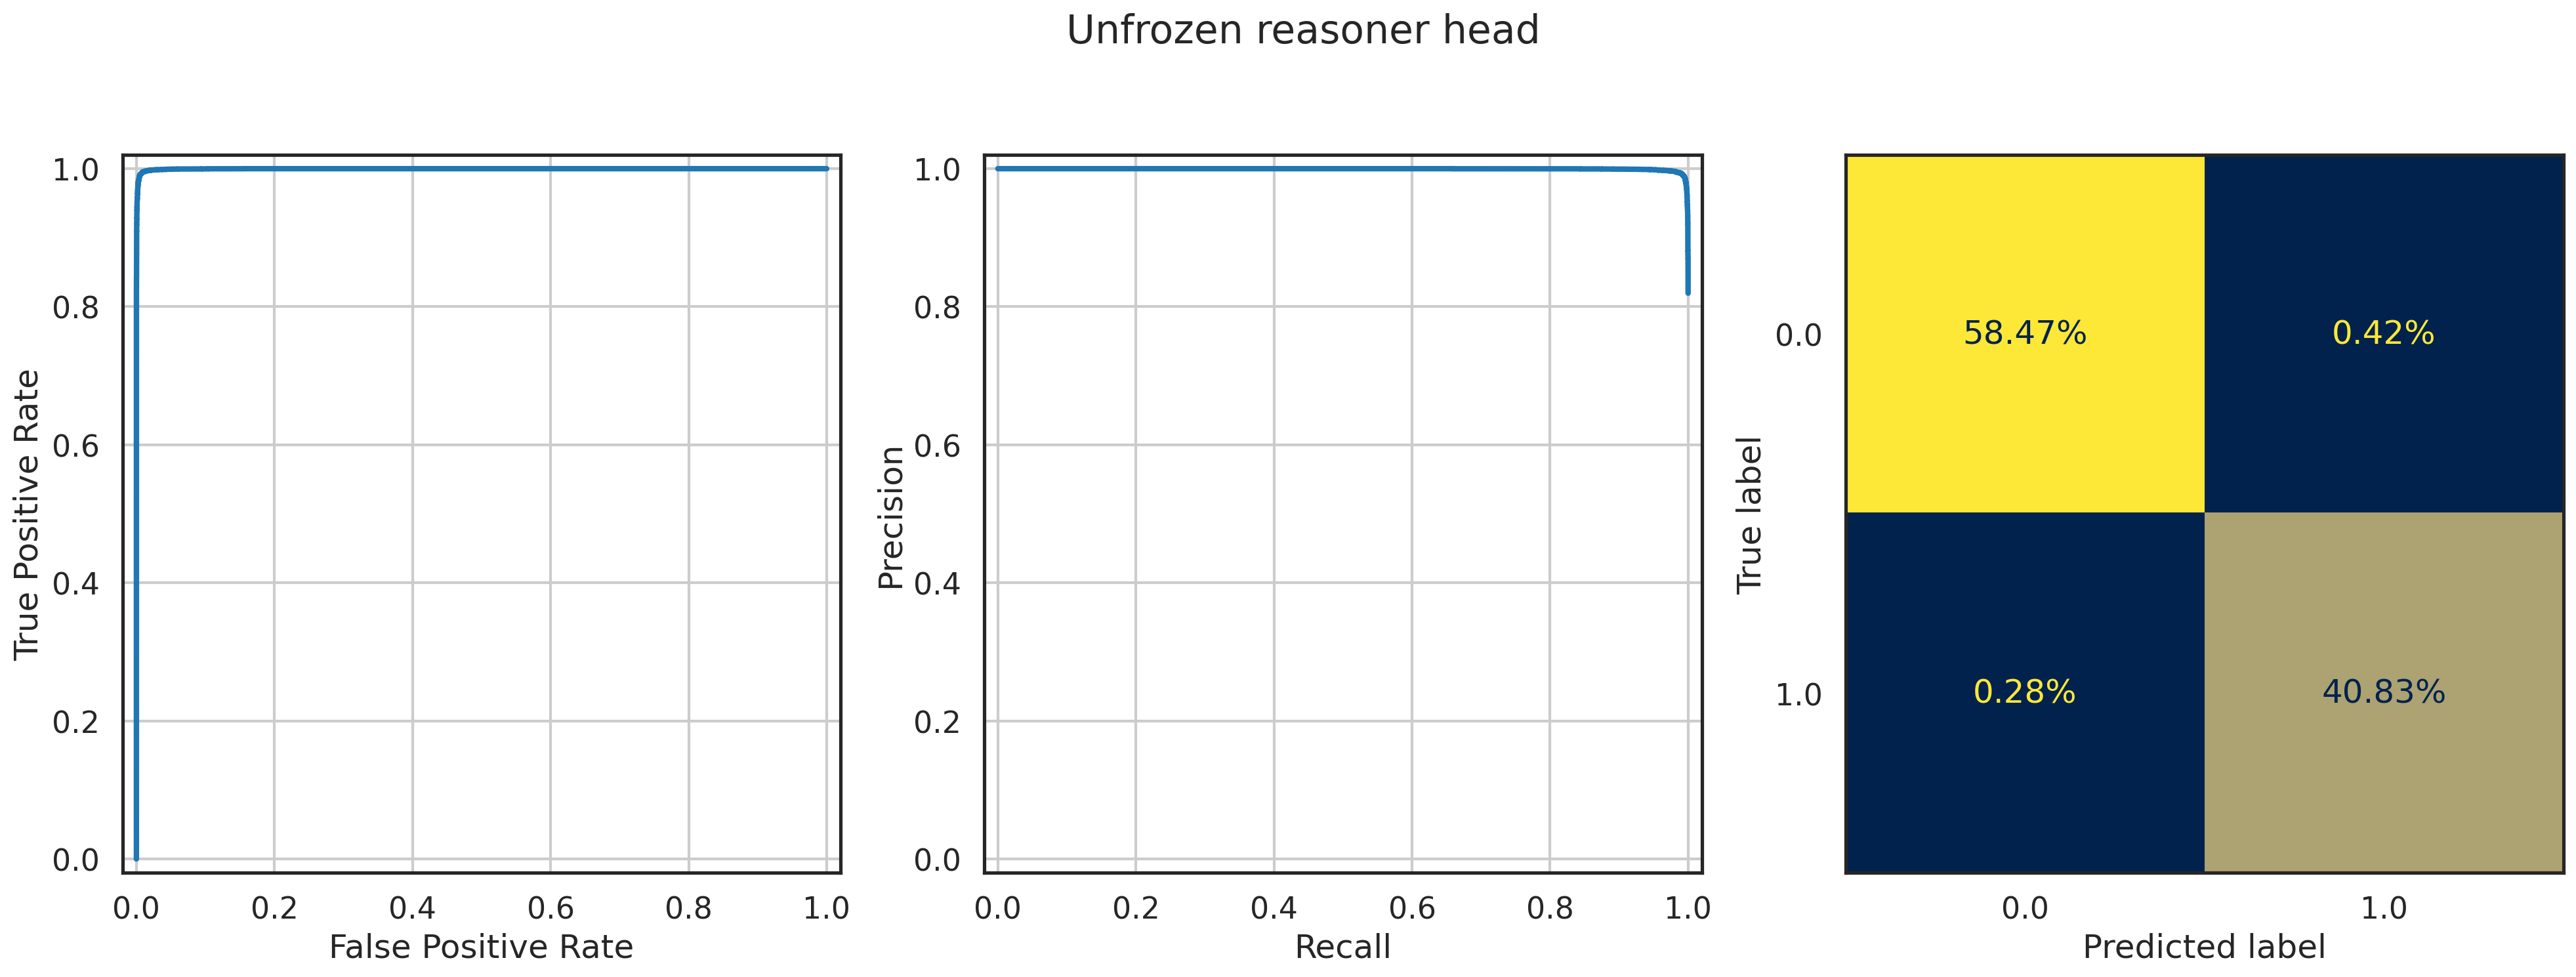

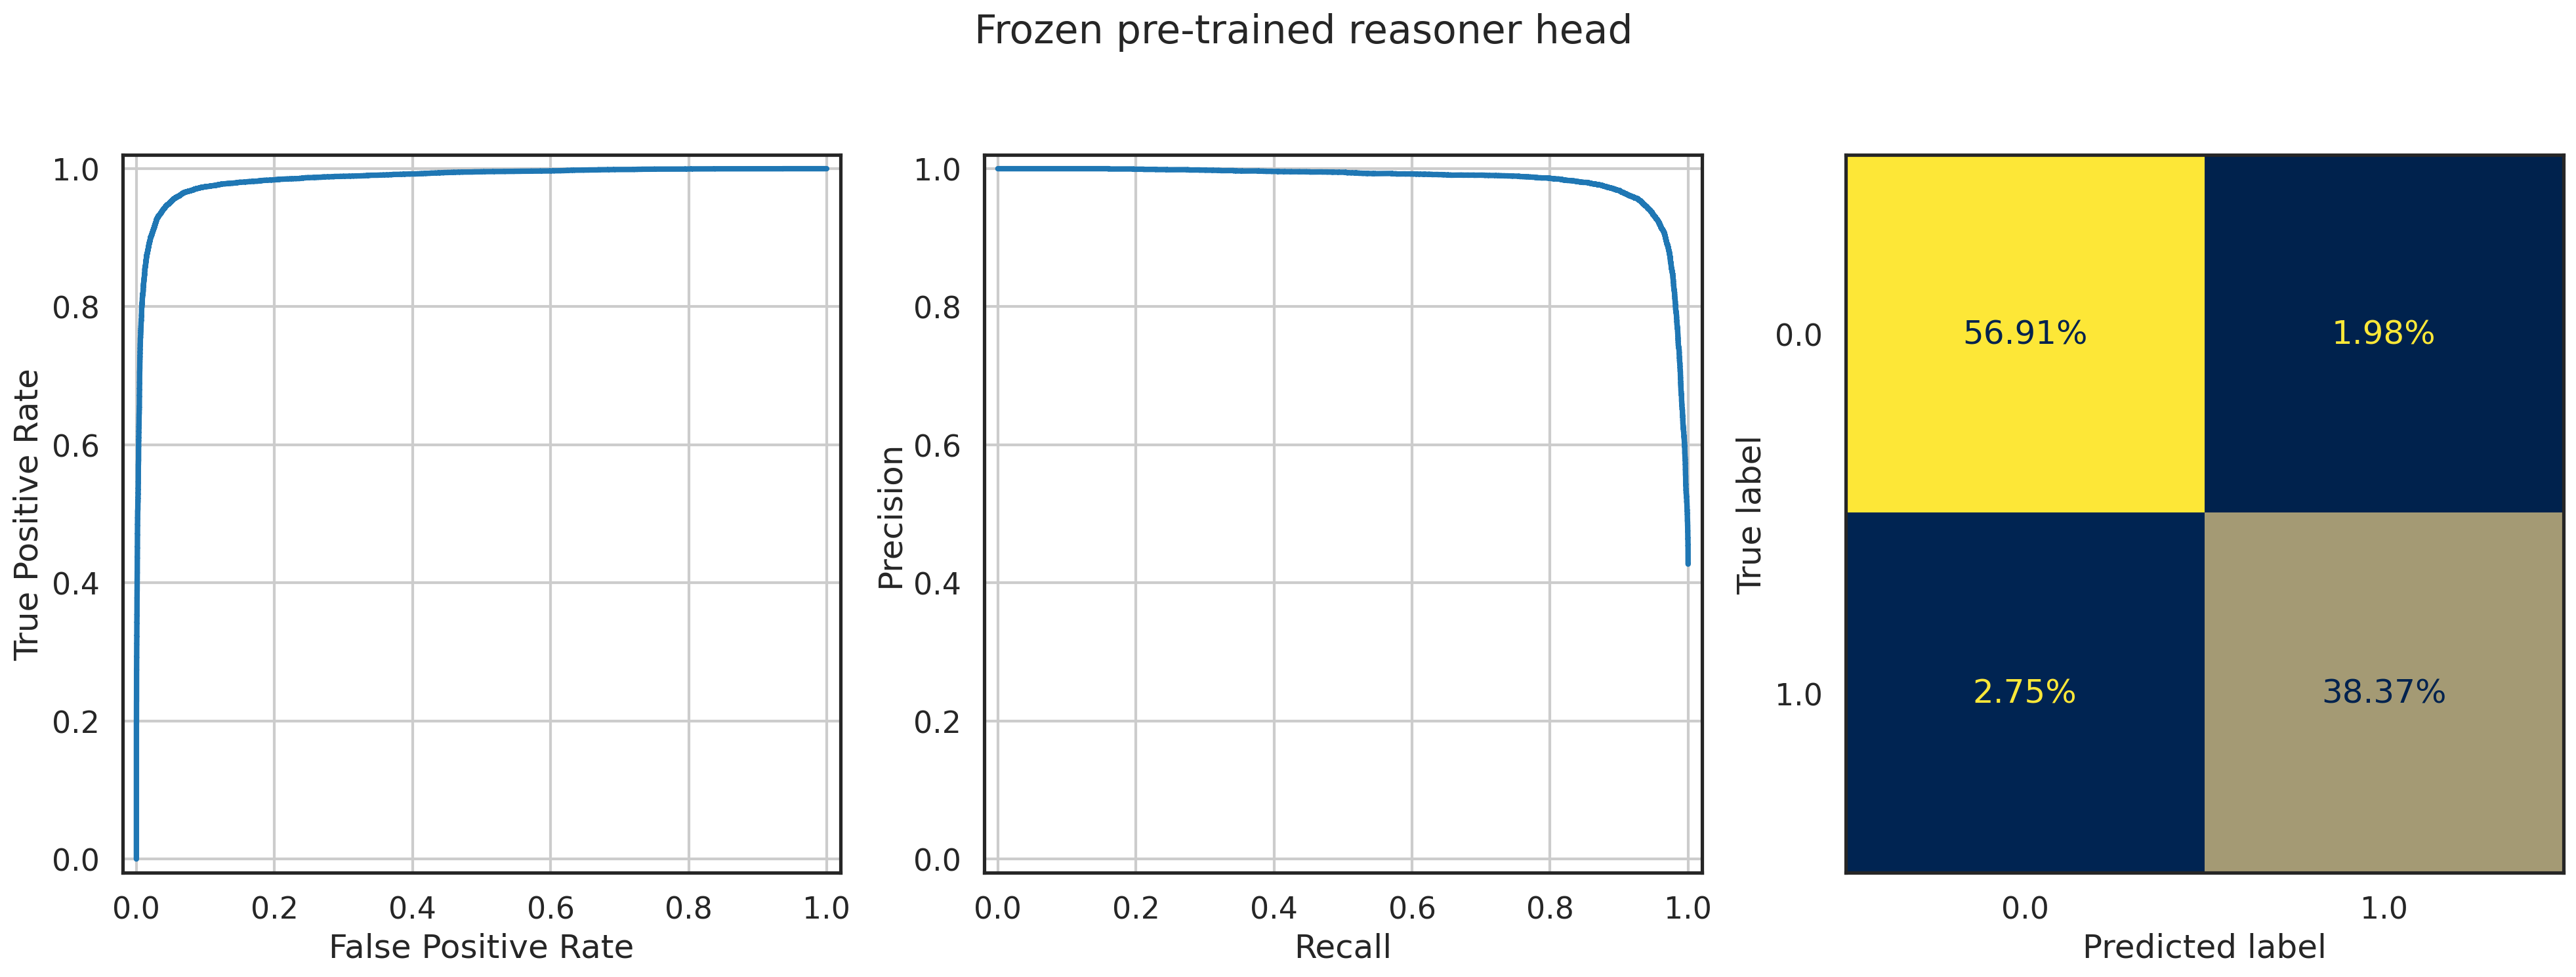

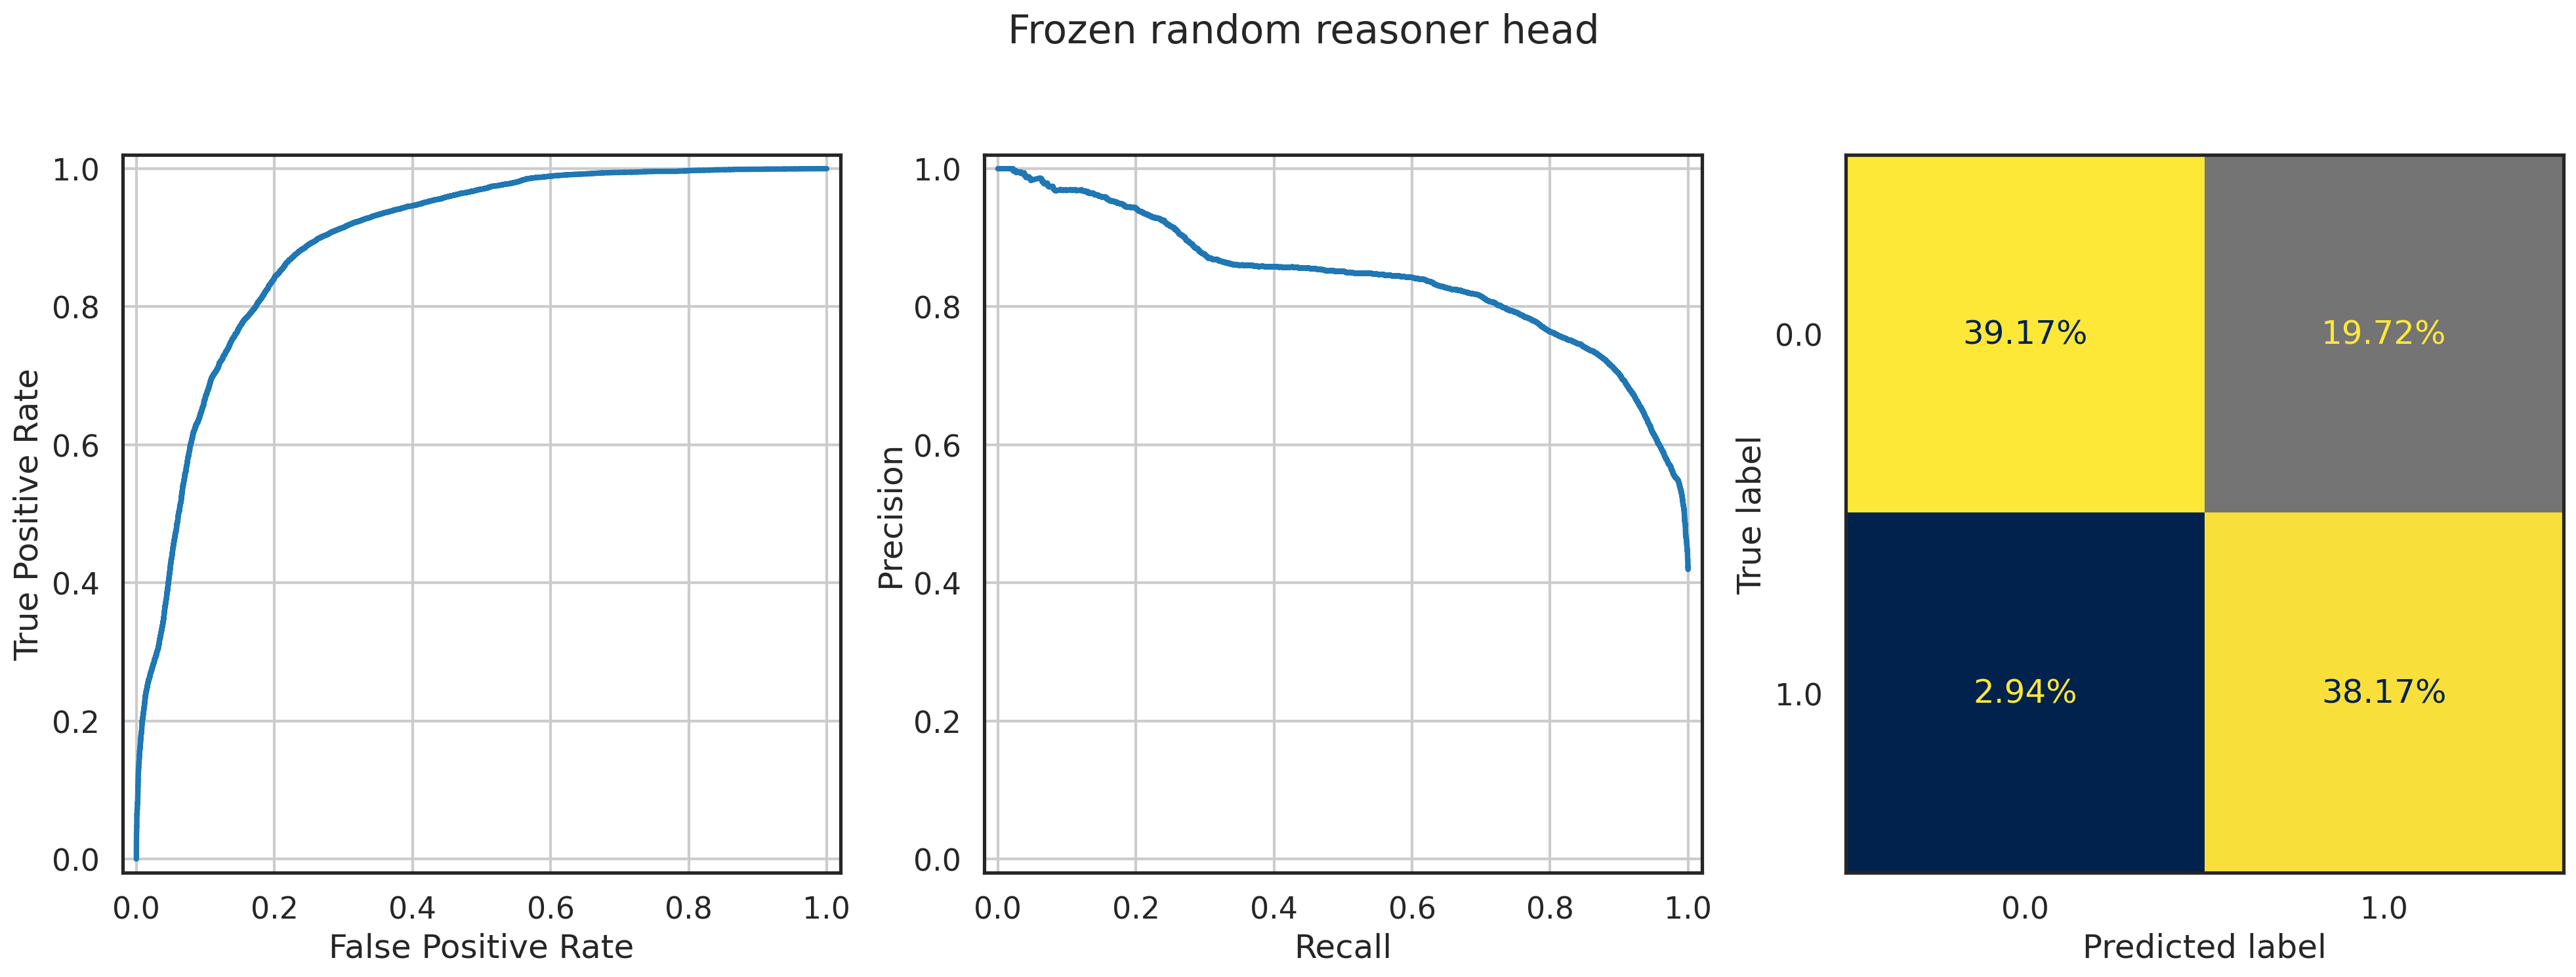

In [6]:
titles = 'Expected', 'Unfrozen reasoner head', 'Frozen pre-trained reasoner head', 'Frozen random reasoner head'
logs = unfrozen_log, transfer_log, random_log
reasoners = unfrozen_r, transfer_r, random_r

for reasoner, log, title in zip(reasoners, logs, titles[1:]):
    print('------')
    with T.no_grad():
        reasoner.eval()
        _, _, Y_te = eval_batch(reasoner.head, [reasoner.embs], X_te, y_te, idx_te)
    print(title)
    print('train time', pd.DataFrame(log.history_tr).groupby('epoch').max().elapsed.sum())
    print(report([onto], y_te, Y_te, idx_te))
    plt.suptitle(title)

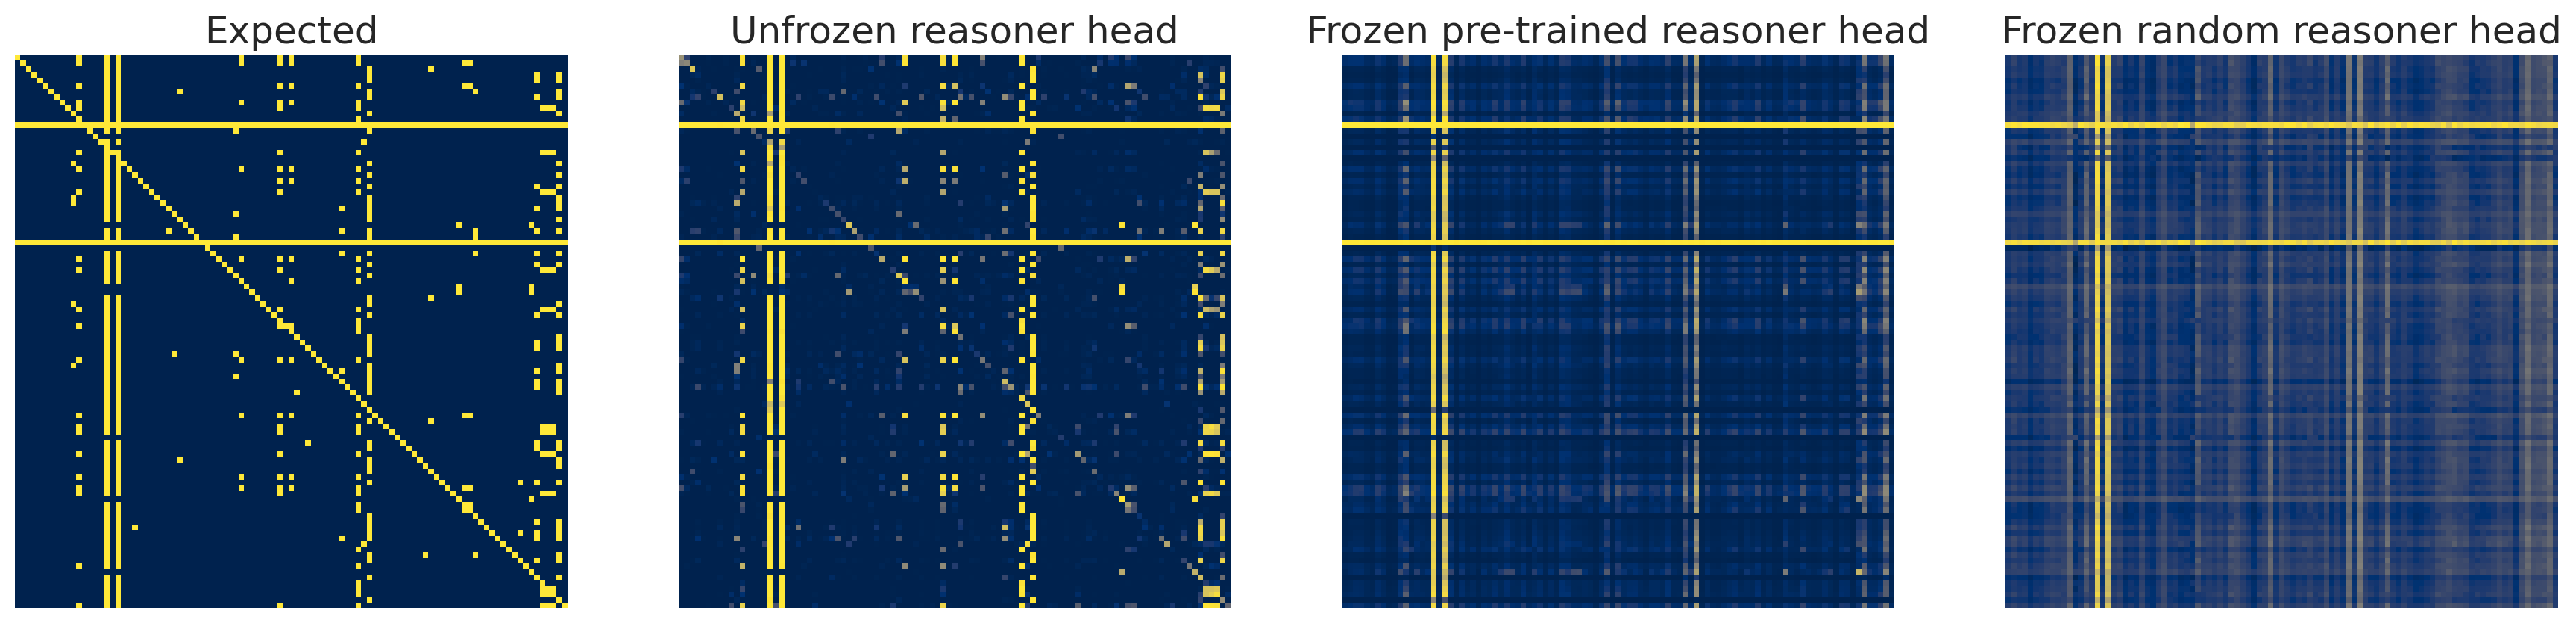

In [7]:
xs = sorted(list(range(onto.n_concepts)), key=lambda i: onto.concepts[i])
ticks = [onto.render(x).replace('Topping', 'T') for x in xs]
n = len(xs)

mats = np.zeros((4, n, n))
for i, c in enumerate(xs):
    for j, d in enumerate(xs):
        mats[0][i][j] = fact.check_sub(c, d)
        mats[1][i][j] = unfrozen_r.check_sub(c, d)
        mats[2][i][j] = transfer_r.check_sub(c, d)
        mats[3][i][j] = random_r.check_sub(c, d)
        
fig, axs = plt.subplots(ncols=4, figsize=(22, 10))
for ax, mat, title in zip(axs, mats, titles):
    sns.heatmap(mat, xticklabels=ticks, yticklabels=ticks, cbar=False, square=True, cmap='cividis', ax=ax)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
plt.grid(True)
plt.show()

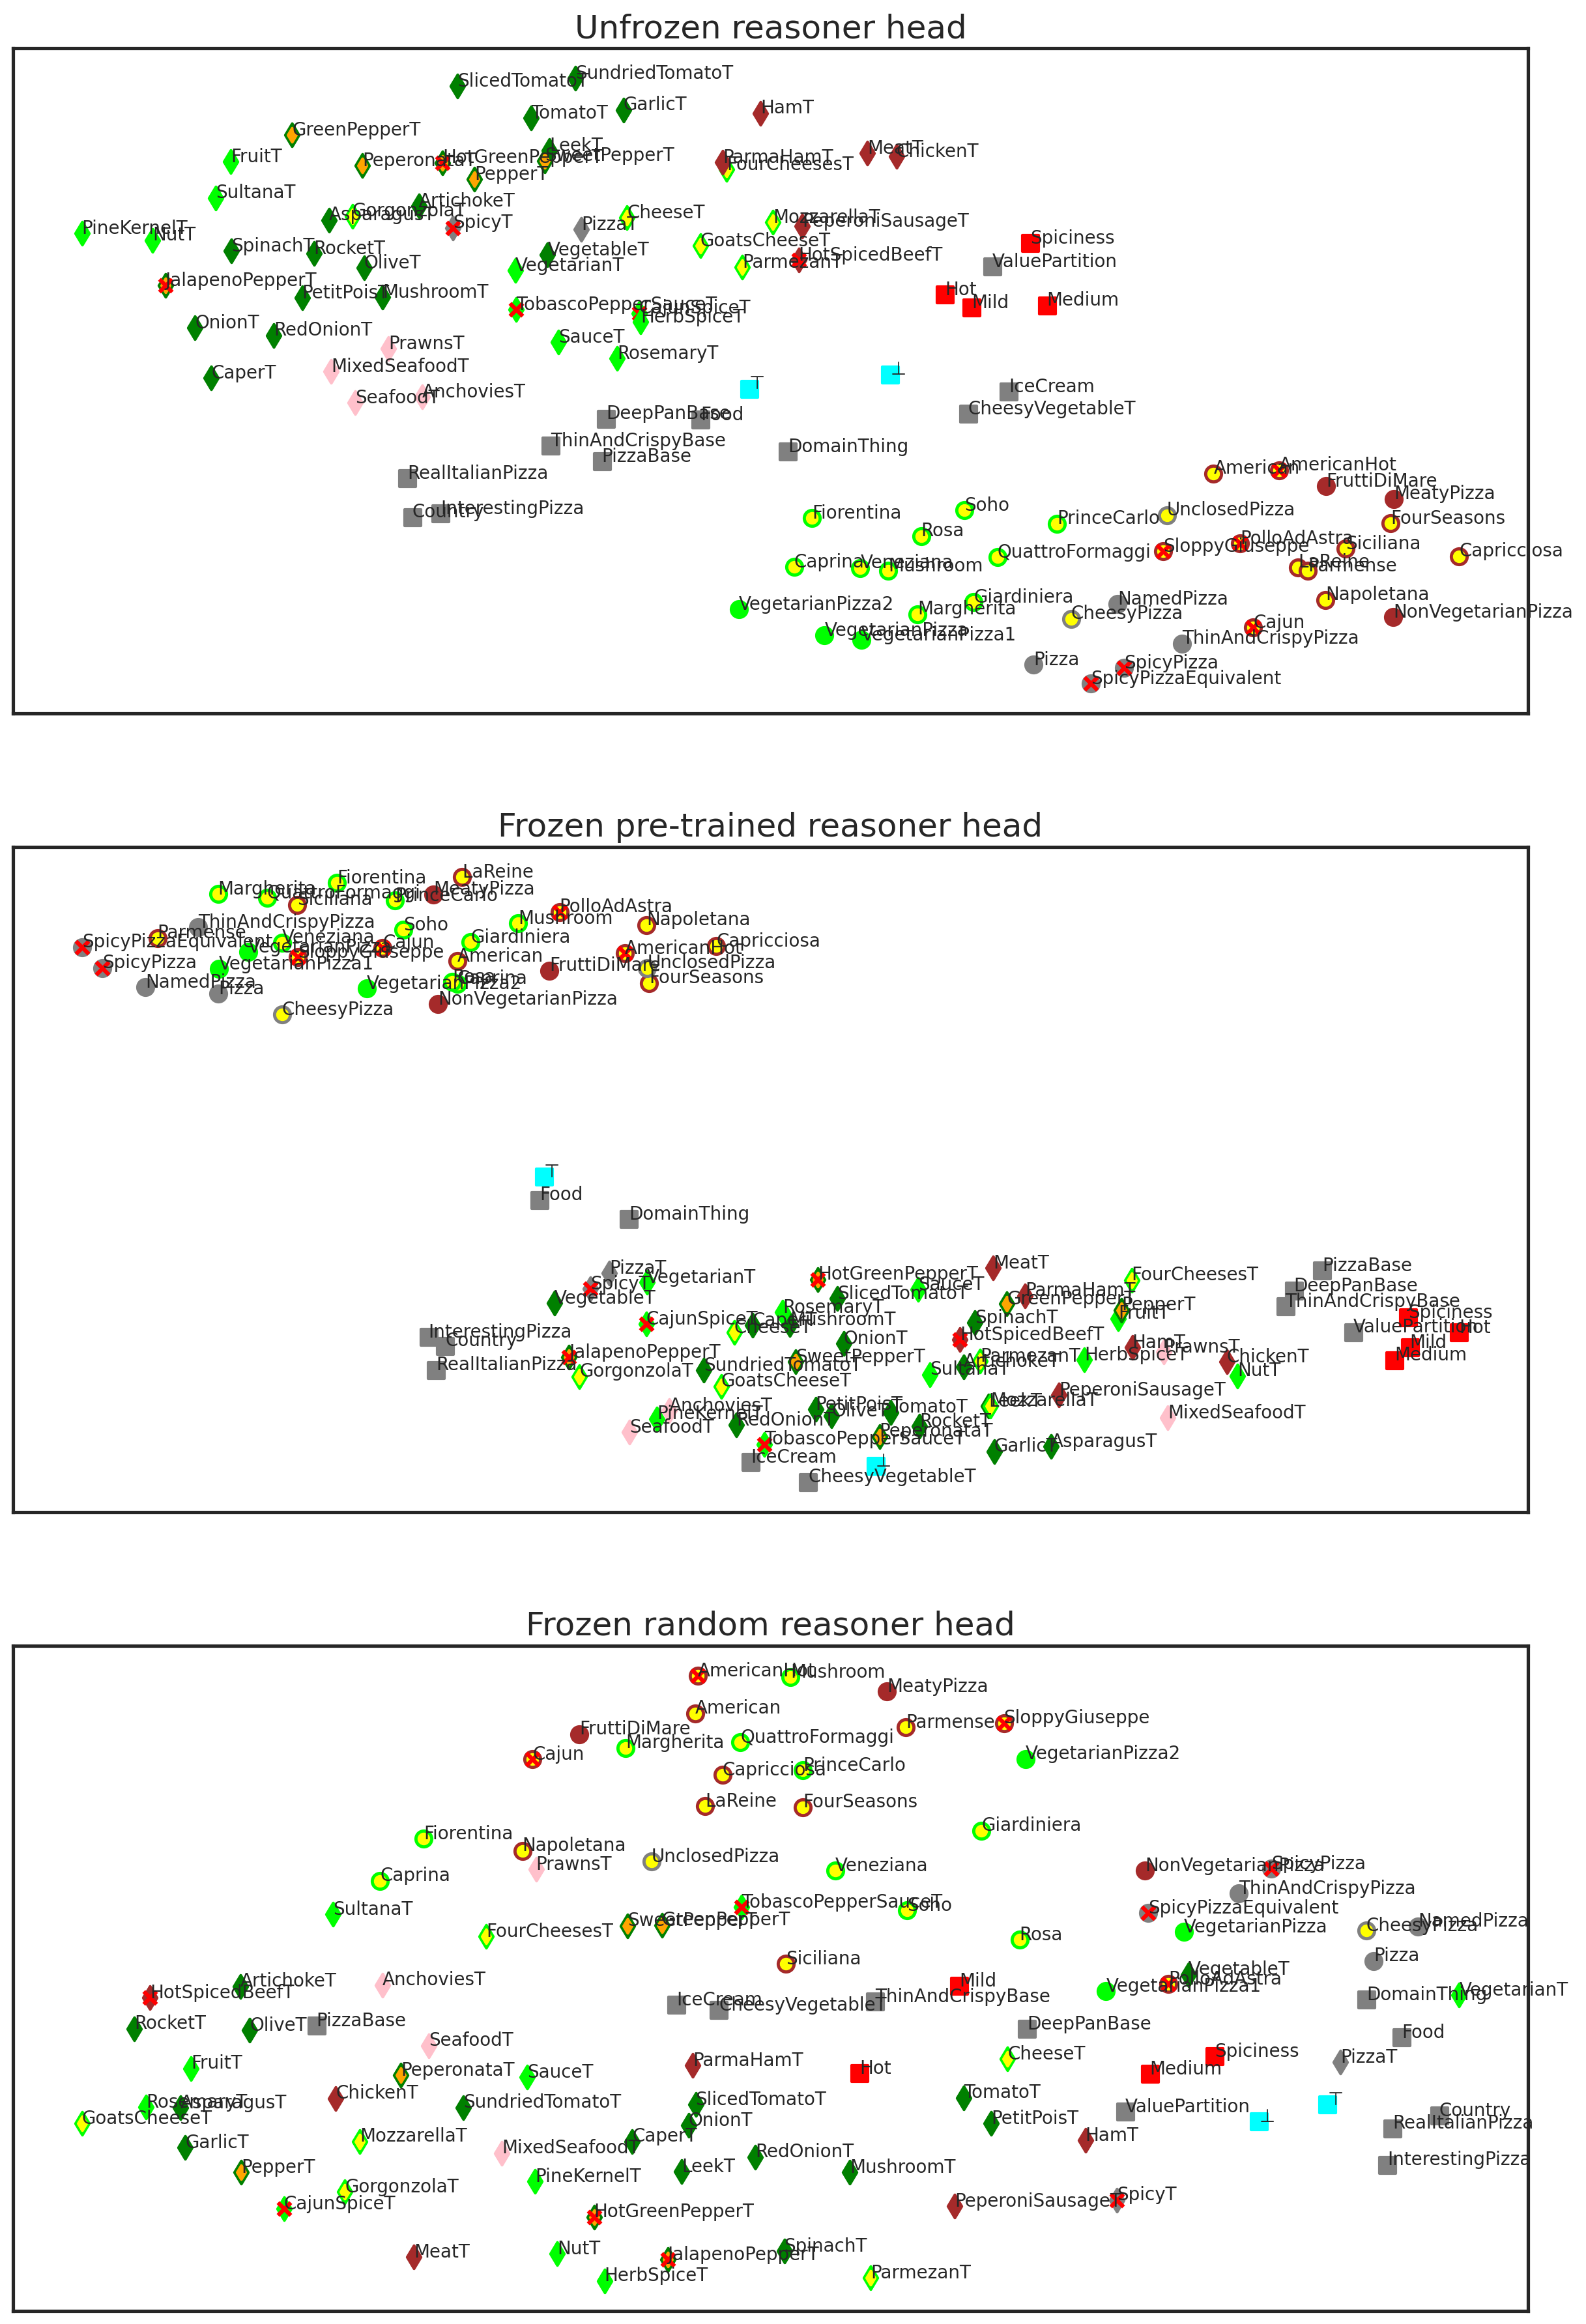

In [12]:
fig, axs = plt.subplots(nrows=3, figsize=(15, 23))
for ax, reasoner, title in zip(axs, reasoners, titles[1:]):
    min_dist = 0.3
    vis_pizza(onto, fact, reasoner, min_dist=min_dist, reload_pca=True, seed=seed, ax=ax)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()